## Proyecto 4 KickOff - Sistema de Recomendación

Un Sistema de Recomendación es un programa o software que crea recomendaciones de productos, servicios, información o contenido a los usuarios, basado en sus preferencias y comportamientos previos (visitar, comprar, dar like, ...)
- Netflix usa sistemas de referencia para recomendar películas o programas de televisión para usuarios individuales que probablemente los vean. 
- Amazon usa sistemas de recomendación para predecir y mostrar una lista de productos que es probable que el cliente compre. 
- Pandora usa sistemas de recomendación de música para sus oyentes.
![](netflix.jpg)

Algunos datos reales: En Netflix se recomiendan 2/3 de las películas vistas. En Google, las recomendaciones de noticias mejoraron la tasa de clics (CTR) en un 38%. Para Amazon, el 35% de las ventas provienen de recomendaciones.
Mediante análisis de datos y aprendizaje automático el sistema determina qué productos (items) son más relevantes para un usuario en particular y recomendarlos en consecuencia.

Hay principalmente 3 tipos de sistemas de recomendación:
1. los basados en contenido (**Content-based**), que utilizan la descripción/atributos de los productos para hacer recomendaciones por su similitud.
![](Content-based-filtering-vs-Collaborative-filtering-Source.png)
2. los sistemas de filtrado colaborativo por usuario (**User-based collaborative filtering**), que buscan usuarios similares (en su cesta de compra) y listan sus items preferidos (comprados).
3. los sistemas de filtrado colaborativo por producto (**Item-Based Collaborative Filtering**), que buscan productos similares (en su historial de compradores).
![](itemVSuser.jpg)
Los sistemas de recomendación se utilizan en sitios web de comercio electrónico (Amazon) y en plataformas de entretenimiento en línea (YouTube) y redes sociales (Instagram). Su objetivo es hacer fácil al usuario encontrar lo que más le puede interesar.

Ejercicio:
![image.png](attachment:image.png)

***
Model-based
En realidad, hay un dos tipos más de sistemas de recomendación que se usan menos y son más difíciles de implementar: híbridos y model-based:
- La falta de diversidad en las recomendaciones se resuelve mediante sistemas **híbridos** (collaborative filtering + content-based) que suman las recomendaciones de los dos sistemas.
- En los **sistemas de recomendación model-based**, el modelo matemático se entrena con datos históricos de interacciones de los usuarios con los elementos para encontrar patrones y relaciones entre ellos. Estos sistemas son capaces de manejar grandes conjuntos de datos y hacer recomendaciones personalizadas para usuarios individuales en función de sus preferencias y comportamientos pasados, **sin tener en cuenta la existencia de otros productos y de otros usuarios de la plataforma**.
![](model-hybrid.png)
***
Proyecto 4
La empresa XYZ se dedica a la fabricación y venta en línea de productos para regalos en cualquier ocasión. Está buscando un Data Scientist para implementar un plan estratégico con el que impulsar las ventas entre sus clientes actuales. En el proceso de selección del que tú eres un candidato, se propone la siguiente prueba técnica: Desarrollar un análisis estadístico para identificar los clientes más potenciales, los productos más consumidos y los meses de mayor frecuencia de compra. Construir un sistema de recomendación de productos según el historial del cliente. Y crear un modelo de detección de bundles.

Objetivos (Especificaciones del desarrollo)
1. Informe de contexto del dataset: productos más vendidos, países con más ventas, horarios pico, etc.
2. Representar gráficamente productos y beneficios por compra.
![](scatter-ventas.png)

2. Obtener 10 productos recomendados (con su descripción) para los usuarios de una plataforma de comercio electrónico.
3. Obtener recomendaciones de **bundles** definidos por los patrones de compra de los usuarios.

DataSet: Disponemos del fichero OnlineRetail.csv (datos anonimizados) que contiene las compras realizadas por los usuarios, así como los parámetros esenciales del producto adquirido.

Hints: Explorar los datos y realizar **limpieza de registros incompletos**. Visualizar valores faltantes con la librería **missingno**
![](graph-missingno.png)

In [1]:
# Importar librerías:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# Matplotlib usa todo el ancho de pantalla:
plt.rcParams.update({'figure.figsize': (10, 7), 'figure.dpi': 120})
import seaborn as sns
from math import sqrt
import geopandas as gpd

In [2]:
# Cargar dataset
df = pd.read_csv('OnlineRetail.csv',  encoding='ISO-8859-1')
#df = pd.read_csv("OnlineRetail.csv", sep = ",")
df.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [ ]:
df.info

In [3]:
df.shape

(541909, 8)

In [5]:
df.count()

InvoiceNo      541909
StockCode      541909
Description    540455
Quantity       541909
InvoiceDate    541909
UnitPrice      541909
CustomerID     406829
Country        541909
dtype: int64

In [6]:
df.dtypes

InvoiceNo       object
StockCode       object
Description     object
Quantity         int64
InvoiceDate     object
UnitPrice      float64
CustomerID     float64
Country         object
dtype: object

In [7]:
type(df)

pandas.core.frame.DataFrame

In [4]:
#df.shape[1]
df.shape

(541909, 8)

In [17]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [3]:
# Eliminamos colunmas innecesarias
df_2 = df.drop(['Description', 'CustomerID', 'InvoiceNo', 'InvoiceDate', 'StockCode'], axis=1)
# Verificamos que no esten las columnas eliminadas
df_2.columns

Index(['Quantity', 'UnitPrice', 'Country'], dtype='object')

In [16]:
# ahora vamos a ver si hay valores faltantes
df_2.isnull().sum()

Quantity     0
UnitPrice    0
Country      0
dtype: int64

In [7]:
df_2.Country.value_counts()  

United Kingdom          495478
Germany                   9495
France                    8557
EIRE                      8196
Spain                     2533
Netherlands               2371
Belgium                   2069
Switzerland               2002
Portugal                  1519
Australia                 1259
Norway                    1086
Italy                      803
Channel Islands            758
Finland                    695
Cyprus                     622
Sweden                     462
Unspecified                446
Austria                    401
Denmark                    389
Japan                      358
Poland                     341
Israel                     297
USA                        291
Hong Kong                  288
Singapore                  229
Iceland                    182
Canada                     151
Greece                     146
Malta                      127
United Arab Emirates        68
European Community          61
RSA                         58
Lebanon 

In [14]:
df_3 = df_2.loc[(df_2['Country'] != "Unspecified")] 
df_3.Country.value_counts()  

United Kingdom          495478
Germany                   9495
France                    8557
EIRE                      8196
Spain                     2533
Netherlands               2371
Belgium                   2069
Switzerland               2002
Portugal                  1519
Australia                 1259
Norway                    1086
Italy                      803
Channel Islands            758
Finland                    695
Cyprus                     622
Sweden                     462
Austria                    401
Denmark                    389
Japan                      358
Poland                     341
Israel                     297
USA                        291
Hong Kong                  288
Singapore                  229
Iceland                    182
Canada                     151
Greece                     146
Malta                      127
United Arab Emirates        68
European Community          61
RSA                         58
Lebanon                     45
Lithuani

In [15]:
df_3.Country.sort_values()

304896         Australia
304931         Australia
304932         Australia
304933         Australia
304934         Australia
               ...      
187072    United Kingdom
187071    United Kingdom
187070    United Kingdom
187083    United Kingdom
270901    United Kingdom
Name: Country, Length: 541463, dtype: object

In [18]:
df_2.shape

(541909, 3)

In [19]:
df_3.shape

(541463, 3)

In [22]:
df_UK = df_2.loc[(df_2['Country'] == "United Kingdom")] 

In [23]:
df_UK

,Quantity,UnitPrice,Country
0,6,2.55,United Kingdom
1,6,3.39,United Kingdom
2,8,2.75,United Kingdom
3,6,3.39,United Kingdom
4,6,3.39,United Kingdom
...,...,...,...
541889,12,1.95,United Kingdom
541890,8,2.95,United Kingdom
541891,24,1.25,United Kingdom
541892,24,8.95,United Kingdom


In [24]:
df_otros_paises = df_2.loc[(df_2['Country'] != "United Kingdom")] 
df_otros_paises.Country.value_counts()  

Germany                 9495
France                  8557
EIRE                    8196
Spain                   2533
Netherlands             2371
Belgium                 2069
Switzerland             2002
Portugal                1519
Australia               1259
Norway                  1086
Italy                    803
Channel Islands          758
Finland                  695
Cyprus                   622
Sweden                   462
Unspecified              446
Austria                  401
Denmark                  389
Japan                    358
Poland                   341
Israel                   297
USA                      291
Hong Kong                288
Singapore                229
Iceland                  182
Canada                   151
Greece                   146
Malta                    127
United Arab Emirates      68
European Community        61
RSA                       58
Lebanon                   45
Lithuania                 35
Brazil                    32
Czech Republic

In [29]:
df_otros_paises_2.columns

Index(['Quantity', 'UnitPrice', 'Country'], dtype='object')

In [26]:
df_otros_paises_2 = df_otros_paises.loc[(df_2['Country'] != "Unspecified")] 
df_otros_paises_2.Country.value_counts()  

Germany                 9495
France                  8557
EIRE                    8196
Spain                   2533
Netherlands             2371
Belgium                 2069
Switzerland             2002
Portugal                1519
Australia               1259
Norway                  1086
Italy                    803
Channel Islands          758
Finland                  695
Cyprus                   622
Sweden                   462
Austria                  401
Denmark                  389
Japan                    358
Poland                   341
Israel                   297
USA                      291
Hong Kong                288
Singapore                229
Iceland                  182
Canada                   151
Greece                   146
Malta                    127
United Arab Emirates      68
European Community        61
RSA                       58
Lebanon                   45
Lithuania                 35
Brazil                    32
Czech Republic            30
Bahrain       

In [30]:
df_otros_paises_2 = df_otros_paises_2[(df_otros_paises_2.Quantity > 100)]
df_otros_paises_2

,Quantity,UnitPrice,Country
6365,1440,0.16,EIRE
7281,120,0.42,Belgium
7282,120,0.42,Belgium
7283,120,0.42,Belgium
17068,120,0.36,Australia
...,...,...,...
534952,1440,1.79,Netherlands
537783,140,1.79,Netherlands
540314,192,1.06,Norway
540342,240,0.12,Norway


In [31]:
df_otros_paises_2.Country.sort_values()

90193       Australia
244593      Australia
108035      Australia
108033      Australia
108031      Australia
             ...     
353091    Switzerland
115570    Switzerland
286863    Switzerland
222313    Switzerland
353101    Switzerland
Name: Country, Length: 1378, dtype: object

In [32]:
df_otros_paises_2.nunique()

Quantity     50
UnitPrice    59
Country      22
dtype: int64

In [33]:
df_otros_paises_2.Country.value_counts(normalize=True)

Netherlands        0.417271
Australia          0.183599
EIRE               0.155298
Sweden             0.079100
France             0.042816
Germany            0.036284
Japan              0.021045
Spain              0.013788
Norway             0.007983
Finland            0.007983
Switzerland        0.007257
Belgium            0.005080
Denmark            0.004354
Portugal           0.003628
Channel Islands    0.003628
Austria            0.002903
Cyprus             0.002177
Canada             0.001451
Hong Kong          0.001451
Italy              0.001451
Iceland            0.000726
Singapore          0.000726
Name: Country, dtype: float64

In [73]:
df_otros_paises_2.Country.value_counts(normalize=True)

Netherlands        0.417271
Australia          0.183599
EIRE               0.155298
Sweden             0.079100
France             0.042816
Germany            0.036284
Japan              0.021045
Spain              0.013788
Norway             0.007983
Finland            0.007983
Switzerland        0.007257
Belgium            0.005080
Denmark            0.004354
Portugal           0.003628
Channel Islands    0.003628
Austria            0.002903
Cyprus             0.002177
Canada             0.001451
Hong Kong          0.001451
Italy              0.001451
Iceland            0.000726
Singapore          0.000726
Name: Country, dtype: float64

In [76]:
df_otros_paises_2 = df_otros_paises_2.loc[df_otros_paises_2['Country'] != "Singapore"] 
df_otros_paises_2.Country.value_counts(normalize=True)

Netherlands        0.418182
Australia          0.184000
EIRE               0.155636
Sweden             0.079273
France             0.042909
Germany            0.036364
Japan              0.021091
Spain              0.013818
Finland            0.008000
Norway             0.008000
Switzerland        0.007273
Belgium            0.005091
Denmark            0.004364
Portugal           0.003636
Channel Islands    0.003636
Austria            0.002909
Cyprus             0.002182
Canada             0.001455
Italy              0.001455
Iceland            0.000727
Name: Country, dtype: float64

In [80]:
# Grabamos el resultado como CSV separado por comas
df_otros_paises_2.to_csv('reducido_P4.csv', index=False)

In [ ]:
# ESTO ES UNA PRUEBA
# Crear un diccionario con los datos
datos = {'paises': ["Netherlands", "Australia","EIRE", "Ireland","Sweden","France"        
                    "Germany", "Japan", "Spain", "Norway", "Finland", "Switzerland",        
                    "Belgium", "Denmark", "Portugal", "Austria", "Cyprus", "Canada","Italy"]}
#paises = ['Germany', 'France', 'EIRE', 'Netherlands', 'Belgium', 'Switzerland', 'Portugal', 'Australia', 'Norway', 'Italy']             
data_filt = df_2[df_2['Country'].isin(datos)]
# Crear el dataframe
ventas = pd.DataFrame(datos)

### Empezar desde aquí

In [81]:
ventas = pd.read_csv("reducido_P4.csv")

In [87]:
ventas.describe()

,Quantity,UnitPrice
count,1375.000000,1375.000000
mean,212.646545,1.160771
std,159.537961,0.970543
min,108.000000,0.000000
25%,144.000000,0.420000
50%,168.000000,1.040000
75%,240.000000,1.450000
max,2400.000000,10.950000


In [88]:
ventas.nunique()

Quantity     50
UnitPrice    59
Country      20
dtype: int64

In [89]:
ventas.duplicated()

0       False
1       False
2        True
3        True
4       False
        ...  
1370    False
1371    False
1372     True
1373     True
1374     True
Length: 1375, dtype: bool

## Gráficos

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [Text(0, 0, 'EIRE'),
  Text(1, 0, 'Belgium'),
  Text(2, 0, 'Australia'),
  Text(3, 0, 'Japan'),
  Text(4, 0, 'Denmark'),
  Text(5, 0, 'France'),
  Text(6, 0, 'Sweden'),
  Text(7, 0, 'Finland'),
  Text(8, 0, 'Netherlands'),
  Text(9, 0, 'Germany'),
  Text(10, 0, 'Spain'),
  Text(11, 0, 'Portugal'),
  Text(12, 0, 'Switzerland'),
  Text(13, 0, 'Channel Islands'),
  Text(14, 0, 'Cyprus'),
  Text(15, 0, 'Austria'),
  Text(16, 0, 'Iceland'),
  Text(17, 0, 'Canada'),
  Text(18, 0, 'Norway'),
  Text(19, 0, 'Italy')])

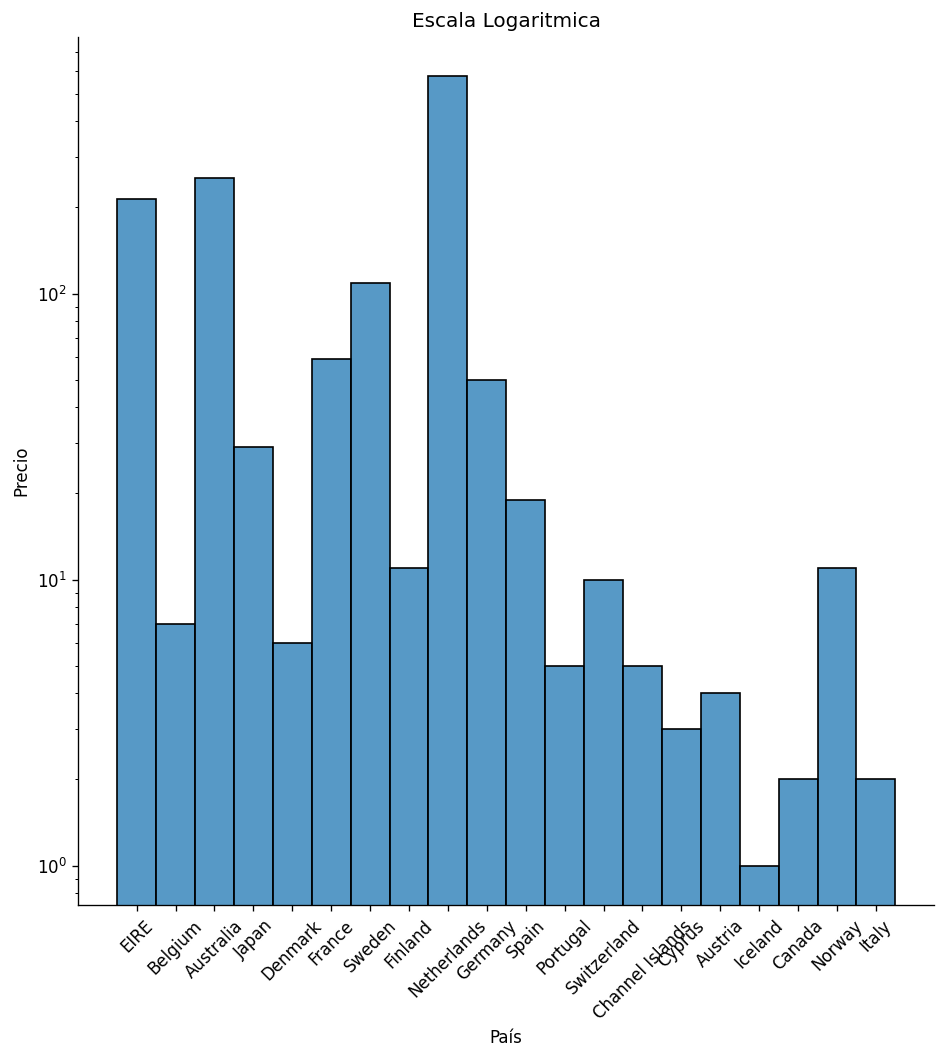

In [99]:
# Matplotlib usa todo el ancho de pantalla:
plt.rcParams.update({'figure.figsize': (10, 8), 'figure.dpi': 120})
figure = sns.displot(data=ventas, x='Country', height=8 ) 
plt.title("Escala Logaritmica")
plt.xlabel("País")
plt.ylabel("Precio")
plt.yscale('log')
# Etiquetas del eje x inclinadas:
plt.xticks(rotation=45)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'France'),
  Text(1, 0, 'Australia'),
  Text(2, 0, 'Netherlands'),
  Text(3, 0, 'Germany'),
  Text(4, 0, 'Norway'),
  Text(5, 0, 'EIRE'),
  Text(6, 0, 'Switzerland'),
  Text(7, 0, 'Portugal'),
  Text(8, 0, 'Italy'),
  Text(9, 0, 'Belgium')])

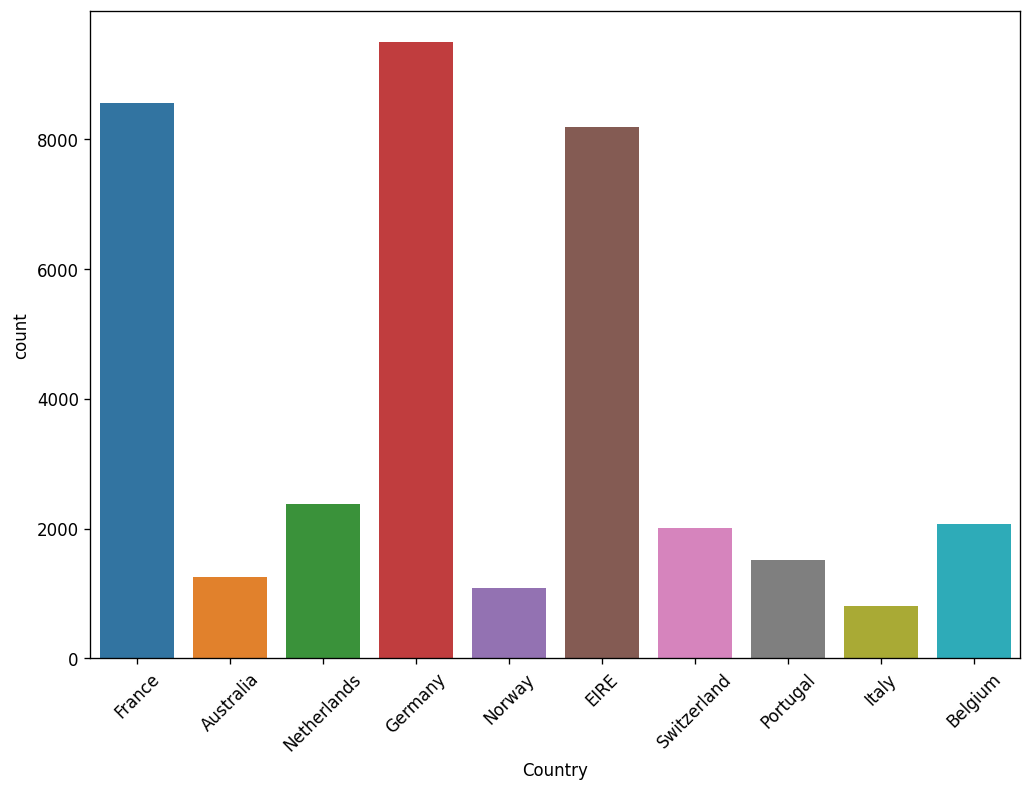

In [6]:
# Gráfico de barras de la proveniencia geografica
sns.countplot(x='Country', data=data_filt_2)
plt.xticks(rotation=45)

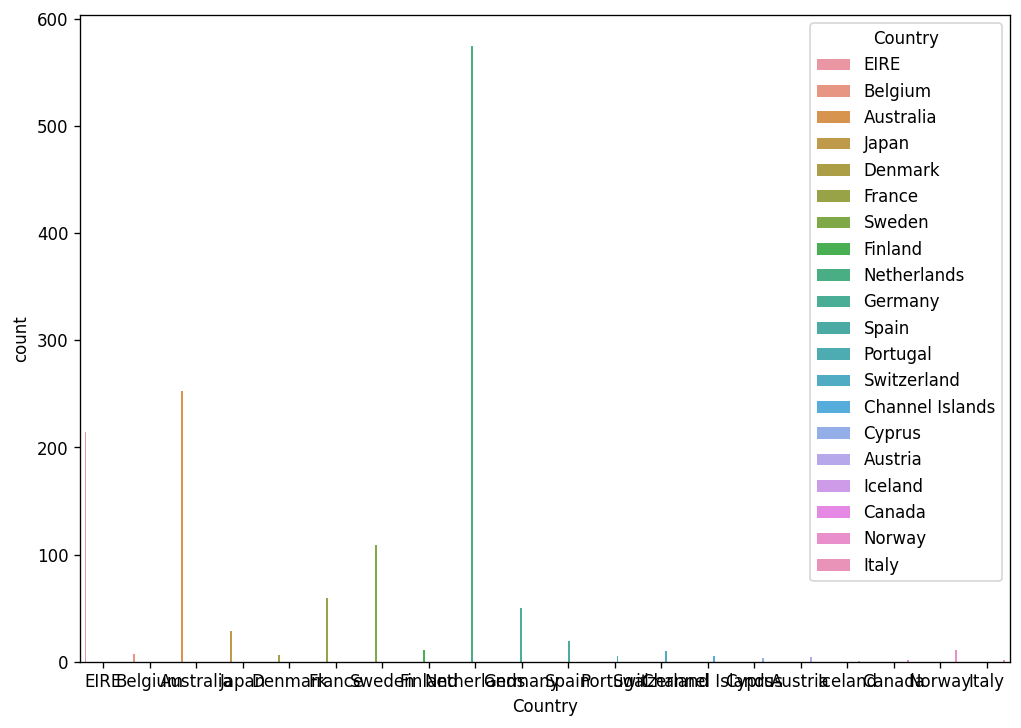

In [100]:
plt.figure(figsize=(10,7))
# Con hue, podemos agrupar por categorías
sns.countplot(data=ventas,x='Country', hue='Country')
plt.show()

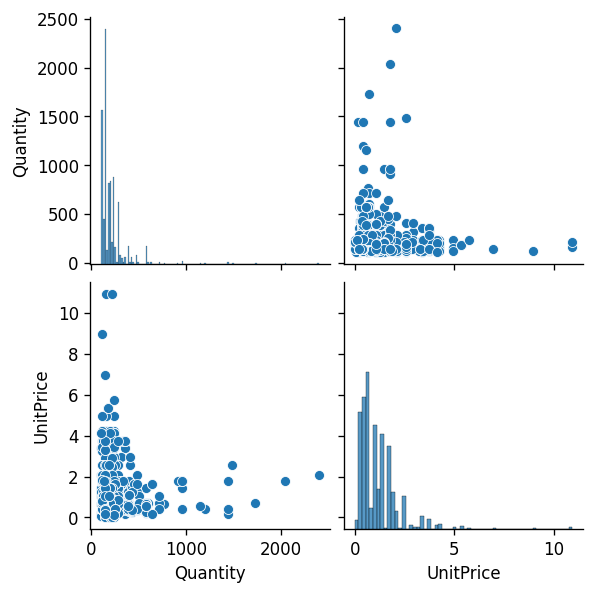

In [102]:
#Pairplot del dataset!
sns.pairplot(ventas)

In [ ]:
# Scatter plot mas linea, para identificar mejor las tendencias
sns.regplot(x='Country', y="UnitPrice", data=ventas)
# Boxplot de la variable success
sns.boxplot(y = 'Country', data = ventas)
#x:variable categórica e y:variable númerica 
# Histograma
sns.distplot(ventas['UnitPrice'])

C:\Users\n_sar\AppData\Local\Temp\ipykernel_12788\1566539124.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = data_filt_2.corr()


<AxesSubplot: >

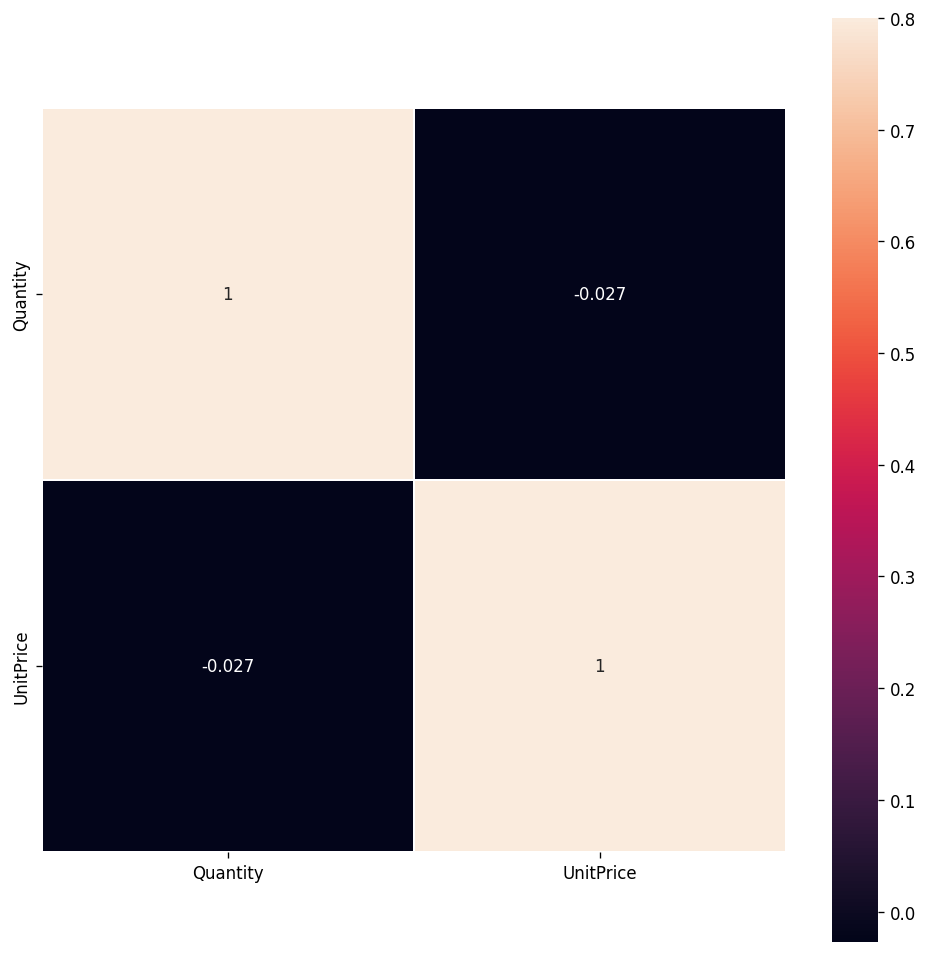

In [13]:
# Mapa de correlaciones
corr = ventas.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(corr, vmax=.8, linewidths=0.01, square=True,annot=True)

In [ ]:
titles=' '.join(ventas.title).lower()
plt.figure(figsize=(15,10))
wordcloud = WordCloud(collocations=True, max_words=500 ).generate(titles)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

2. Construir un mapa que muestre número de compras totales por país y otro con número de compras relativas (per capita) por país.

![](mapa.png)

In [106]:
# Lee los datos de los límites de los países
paises_geo_pandas = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
# Ver el listado completo
pd.set_option('display.max_rows', 200)
paises_geo_pandas.name.sort_values

<bound method Series.sort_values of 0                          Fiji
1                      Tanzania
2                     W. Sahara
3                        Canada
4      United States of America
5                    Kazakhstan
6                    Uzbekistan
7              Papua New Guinea
8                     Indonesia
9                     Argentina
10                        Chile
11              Dem. Rep. Congo
12                      Somalia
13                        Kenya
14                        Sudan
15                         Chad
16                        Haiti
17               Dominican Rep.
18                       Russia
19                      Bahamas
20                 Falkland Is.
21                       Norway
22                    Greenland
23       Fr. S. Antarctic Lands
24                  Timor-Leste
25                 South Africa
26                      Lesotho
27                       Mexico
28                      Uruguay
29                       Brazil
30  

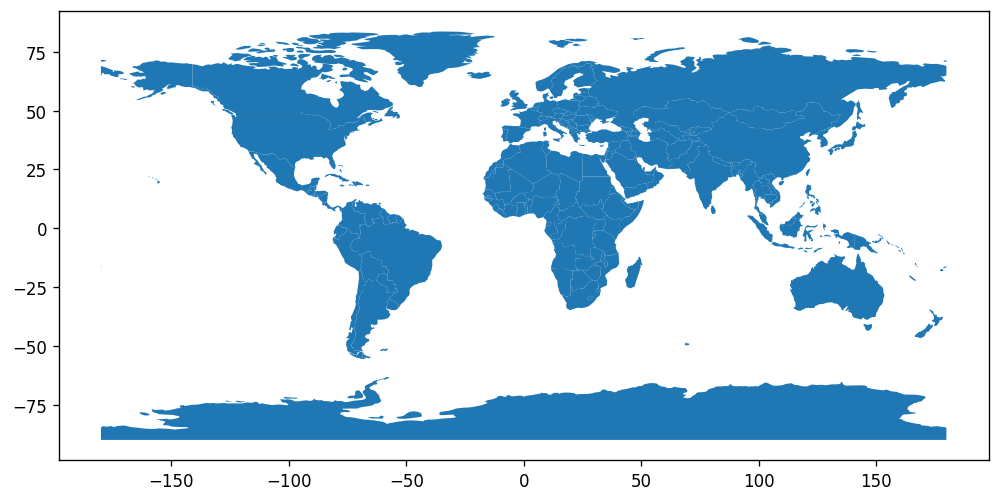

In [107]:
# Verificar si coincide losnombre d elos países del data frame con los del geopandas
paises_geo_pandas.loc[paises_geo_pandas["name"]=="Iceland"]
# Crea una figura y un eje
fig, ax = plt.subplots(figsize=(10, 6))
# Dibuja los países en el mapa
paises_geo_pandas.plot(ax=ax)
# Muestra el mapa
plt.show()   

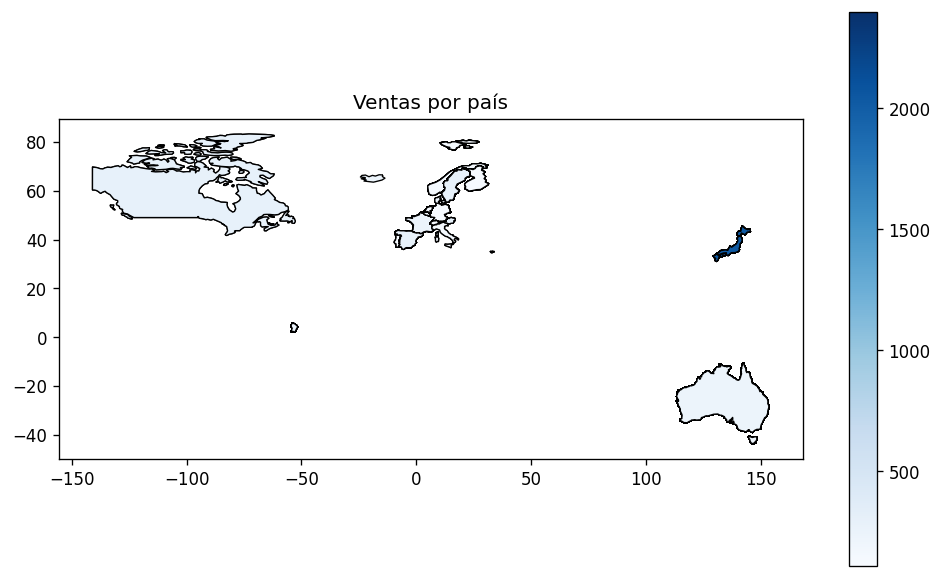

In [108]:
# Unir los datos de los países con los datos de ventas por país
paises_ventas = paises_geo_pandas.merge(ventas, left_on='name', right_on='Country')
# Crear una figura y un eje
fig, ax = plt.subplots(figsize=(10, 6))
# Dibujar los países en el mapa y colorearlos según las ventas
paises_ventas.plot(ax=ax, column='Quantity', cmap='Blues', linewidth=0.8, edgecolor='black', legend=True)
# Añadir un título al mapa
ax.set_title('Ventas por país')
plt.show()

3. Analizar los horarios y calendarios de compra, mediante histogramas y estacionalidad.

![](ventas-por-meses.png)
![](pieChart.png)

4. Crear la **Customer-Item Matrix** mediante el método df.pivot_table

![](pivot-table.png)

5. Crear la **User to User Similarity Matrix** mediante la **distancia del coseno** con la librería sklearn

![](An-example-of-user-similarity-matrix-of-k-RRI.png)

6. Obtener las 10 recomendaciones de tipo **filtrado colaborativo por usuario**.

7. Obtener las 10 recomendaciones de tipo **filtrado colaborativo por producto** creando previamente la **Item to Item Similarity Matrix**.

8. Obtener las 10 recomendaciones de tipo **basado en contenido** utilizando métricas de texto (Levenshtein o vectorización TF-IDF)

9. Realizar un **market basket analysis** para detectar **bundles** (packs) de productos. Algoritmos de clusterización como K-means podrían detectar los bundles más frecuentes.